# NBS <a id='network-based-statistic'></a>


    '''
    Performs the NBS for populations X and Y for a t-statistic threshold of
    alpha.
    Parameters
    ----------
    x : NxNxP np.ndarray
        matrix representing the first population with P subjects. must be
        symmetric.
    y : NxNxQ np.ndarray
        matrix representing the second population with Q subjects. Q need not
        equal P. must be symmetric.
    thresh : float
        minimum t-value used as threshold
    k : int
        number of permutations used to estimate the empirical null 
        distribution
    tail : {'left', 'right', 'both'}
        enables specification of particular alternative hypothesis
        'left' : mean population of X < mean population of Y
        'right' : mean population of Y < mean population of X
        'both' : means are unequal (default)
    paired : bool
        use paired sample t-test instead of population t-test. requires both
        subject populations to have equal N. default value = False
    verbose : bool
        print some extra information each iteration. defaults value = False
    seed : hashable, optional
        If None (default), use the np.random's global random state to generate random numbers.
        Otherwise, use a new np.random.RandomState instance seeded with the given value.

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib  # load the beta maps in python
from nilearn import plotting  # plot nifti images
from bct import nbs
from scipy.io import savemat
from mne.viz import plot_connectivity_circle

/usr/local/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
data_dir = '/Volumes/psybrain/ADM/derivatives'
results_dir = '/Volumes/schnyer/Megan/adm_mem-fc/analysis/withhc/stats/'
nibs_dir='/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc'

tasks = ['MemMatch1', 'MemMatch2', 'MemMatch3']
trial_types = ['cue', 'match', 'mismatch']

atlas_file='/Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz'
atlas_lut='/Volumes/psybrain/ADM/derivatives/nibs/power264_labels.tsv'

In [5]:
atlas = pd.read_csv(atlas_lut, sep='\t').set_index('index')
atlas = atlas.append({'regions': 'HC Sherman'}, ignore_index=True)
atlas.regions.unique()

array(['Uncertain', 'Sensory/somatomotor Hand',
       'Sensory/somatomotor Mouth', 'Cingulo-opercular Task Control',
       'Auditory', 'Default mode', 'Memory retrieval?',
       'Ventral attention', 'Visual', 'Fronto-parietal Task Control',
       'Salience', 'Subcortical', 'Cerebellar', 'Dorsal attention',
       'HC Sherman'], dtype=object)

In [6]:
atlas=atlas.drop([3,9,183], axis=0)
atlas = atlas.reset_index(drop=True)

In [7]:
hc = atlas.loc[atlas['regions'].str.contains('HC')].index.tolist()
dmn = atlas.loc[atlas['regions'].str.contains('Default')].index.tolist()
mem = atlas.loc[atlas['regions'].str.contains('Memory')].index.tolist()
fpn = atlas.loc[atlas['regions'].str.contains('Fronto-parietal')].index.tolist()

dmn_hc = np.concatenate((dmn, hc))
fpn_hc = np.concatenate((fpn, hc))
mem_hc = np.concatenate((mem, hc))

dmn_fpn = np.concatenate((dmn, fpn, hc))
dmn_mem = np.concatenate((dmn, mem, hc))
fpn_mem = np.concatenate((fpn, mem, hc))
dmn_fpn_mem = np.concatenate((dmn, fpn, mem, hc))

In [8]:
x = np.load('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/memmatch_fc_withhc_clean.npy', allow_pickle=True).flat[0]
fc_subs = np.loadtxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/fcsubs.txt', dtype=str)

## Net 1

In [74]:
adj = np.loadtxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/adj_oagtya_dmnfpnhc_t35_network1_plt05_extent.txt')
coords = np.loadtxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/coords_dmn_fpn_hc.txt', dtype=int)
print(adj.shape)
nbs_mat = np.repeat(adj[:, :, np.newaxis], x['cue'].shape[2], axis=2)*x['cue'][dmn_fpn][:,dmn_fpn,:]

np.fill_diagonal(adj, -1.0, wrap=False)
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/network1.edge', adj, fmt='%s', delimiter=' ')

(84, 84)


In [75]:
edges_fc = pd.DataFrame(nbs_mat[np.where(np.triu(adj) == 1)].T)
edges_fc.columns = ['net1_edge_' + str(col) for col in edges_fc.columns]
edges_fc['net1_mean'] = edges_fc.mean(axis=1)
edges_fc.head()

,net1_edge_0,net1_edge_1,net1_edge_2,net1_edge_3,net1_mean
0,-0.196271,-0.502225,-0.195720,0.225723,-0.167123
1,-0.122611,-0.040517,-0.042800,-0.155228,-0.090289
2,0.220404,0.536647,0.603279,0.074852,0.358795
3,0.184874,0.175133,0.136257,0.142421,0.159671
4,0.288184,-0.067531,0.078085,0.070694,0.092358


In [76]:
edges = pd.DataFrame(np.hstack((coords, atlas.loc[dmn_fpn].values)))
edges[[3]] = np.where(edges[[3]] == 'Default mode', 0, edges[[3]])
edges[[3]] = np.where(edges[[3]] == 'Fronto-parietal Task Control', 1, edges[[3]])
edges[[3]] = np.where(edges[[3]] == 'HC Sherman', 2, edges[[3]])
edges['new'] = 1
edges['newnew'] = 1
edges.to_csv('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/dmn_fpn_hc.node', index=False, header=None, sep=' ')

In [77]:
edgesList0 = list([np.where(np.triu(adj) == 1)][0][0])
edgesList1 = list([np.where(np.triu(adj) == 1)][0][1])
pd.DataFrame(node_labels).loc[edgesList0].reset_index(drop=True)

,0,1,2,3
0,59,-17,29,Default mode
1,59,-17,29,Default mode
2,59,-17,29,Default mode
3,-18,63,-9,Default mode


In [78]:
pd.DataFrame(node_labels).loc[edgesList1].reset_index(drop=True)

,0,1,2,3
0,-42,38,21,Fronto-parietal Task Control
1,-42,-55,45,Fronto-parietal Task Control
2,33,-53,44,Fronto-parietal Task Control
3,-42,38,21,Fronto-parietal Task Control


(<Figure size 1080x1080 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x1281ecf10>)

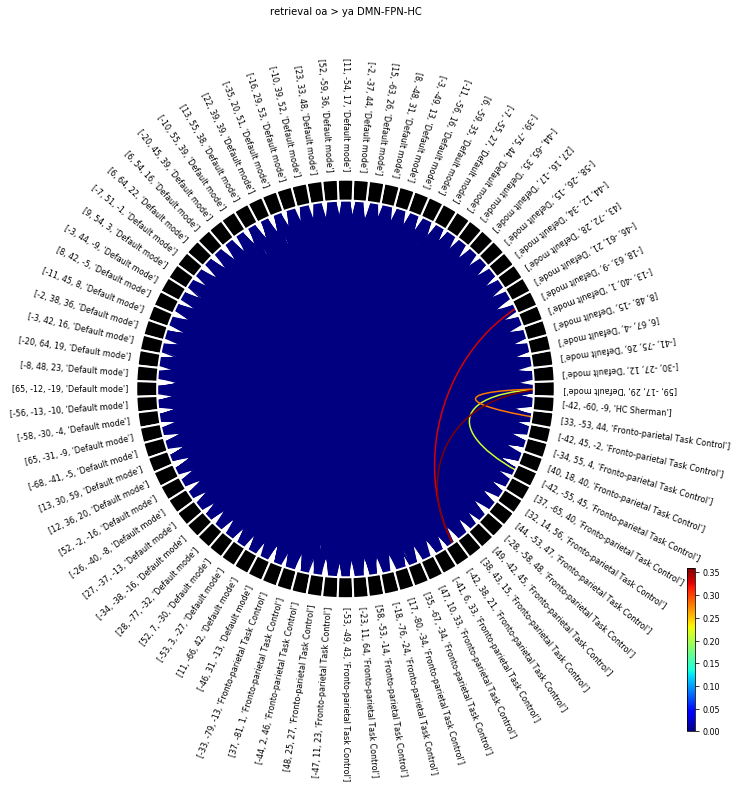

In [128]:
fig = plt.figure(figsize=(15, 15))
n_lines = int(np.sum((nbs_mat > 0) / 2))
node_labels = pd.DataFrame(np.hstack((coords, atlas.loc[dmn_fpn].values))).values.tolist()


plot_connectivity_circle(nbs_mat.mean(axis=2), node_labels, n_lines=n_lines, fig=fig, title='retrieval oa > ya DMN-FPN-HC', 
                         fontsize_title=10, facecolor='white', textcolor='black', 
                         colormap='jet', colorbar=1, node_colors=['black'], 
                         node_edgecolor=['white'], show=False, interactive=False)

In [129]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -18,63,-9
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -42,38,21

<b>Harvard-Oxford Cortical Structural Atlas</b><br>64% Frontal Pole
<b>Harvard-Oxford Cortical Structural Atlas</b><br>37% Frontal Pole, 25% Middle Frontal Gyrus, 7% Inferior Frontal Gyrus, pars triangularis


In [130]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c 59,-17,29
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c 33,-53,44

<b>Harvard-Oxford Cortical Structural Atlas</b><br>40% Postcentral Gyrus, 23% Supramarginal Gyrus, anterior division, 2% Parietal Operculum Cortex
<b>Harvard-Oxford Cortical Structural Atlas</b><br>25% Superior Parietal Lobule, 21% Angular Gyrus, 8% Lateral Occipital Cortex, superior division, 2% Supramarginal Gyrus, posterior division


In [131]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c 59,-17,29
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -42,-55,45

<b>Harvard-Oxford Cortical Structural Atlas</b><br>40% Postcentral Gyrus, 23% Supramarginal Gyrus, anterior division, 2% Parietal Operculum Cortex
<b>Harvard-Oxford Cortical Structural Atlas</b><br>23% Angular Gyrus, 14% Supramarginal Gyrus, posterior division, 10% Superior Parietal Lobule, 5% Lateral Occipital Cortex, superior division


In [132]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c 59,-17,29
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -42,38,21

<b>Harvard-Oxford Cortical Structural Atlas</b><br>40% Postcentral Gyrus, 23% Supramarginal Gyrus, anterior division, 2% Parietal Operculum Cortex
<b>Harvard-Oxford Cortical Structural Atlas</b><br>37% Frontal Pole, 25% Middle Frontal Gyrus, 7% Inferior Frontal Gyrus, pars triangularis


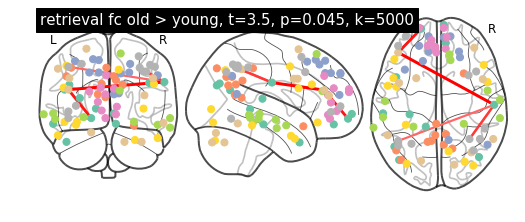

In [133]:
from nilearn import plotting

plotting.plot_connectome(nbs_mat.mean(axis=2), coords, edge_threshold=0, title='retrieval fc old > young, t=3.5, p=0.045, k=5000')



## Net 2

In [79]:
adj = np.loadtxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/adj_oagtya_dmnfpnhc_t35_network2_plt05_extent.txt')
coords = np.loadtxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/coords_dmn_fpn_hc.txt', dtype=int)
print(adj.shape)
nbs_mat = np.repeat(adj[:, :, np.newaxis], x['cue'].shape[2], axis=2)*x['cue'][dmn_fpn][:,dmn_fpn,:]

np.fill_diagonal(adj, -1, wrap=False)    
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/network2.edge', adj, fmt='%s', delimiter=' ')

(84, 84)


In [80]:
edges_fc2 = pd.DataFrame(nbs_mat[np.where(np.triu(adj) == 1)].T)
edges_fc2.columns = ['net2_edge_' + str(col) for col in edges_fc2.columns]
edges_fc2['net2_mean'] = edges_fc2.mean(axis=1)
edges_fc2.head()

,net2_edge_0,net2_edge_1,net2_edge_2,net2_edge_3,net2_edge_4,net2_edge_5,net2_edge_6,net2_mean
0,-0.205713,-0.247074,-0.299411,-0.213041,0.154262,0.166165,0.475662,-0.024164
1,0.131732,0.019913,-0.139218,-0.116758,-0.111342,-0.016313,-0.130363,-0.051764
2,0.018266,-0.184343,-0.123546,0.151649,-0.165448,0.240018,0.164579,0.014454
3,0.223740,-0.137745,0.438200,-0.149578,0.432467,-0.049099,-0.270793,0.069599
4,0.483757,-0.259284,0.023039,0.155893,0.003748,0.169311,-0.040877,0.076512


In [81]:
edges_df = edges_fc.join(edges_fc2)
edges_df['subject'] = fc_subs
edges_df.to_csv('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/edgesdf.csv', index=False)
edges_df.head()

,net1_edge_0,net1_edge_1,net1_edge_2,net1_edge_3,net1_mean,net2_edge_0,net2_edge_1,net2_edge_2,net2_edge_3,net2_edge_4,net2_edge_5,net2_edge_6,net2_mean,subject
0,-0.196271,-0.502225,-0.195720,0.225723,-0.167123,-0.205713,-0.247074,-0.299411,-0.213041,0.154262,0.166165,0.475662,-0.024164,30004
1,-0.122611,-0.040517,-0.042800,-0.155228,-0.090289,0.131732,0.019913,-0.139218,-0.116758,-0.111342,-0.016313,-0.130363,-0.051764,30008
2,0.220404,0.536647,0.603279,0.074852,0.358795,0.018266,-0.184343,-0.123546,0.151649,-0.165448,0.240018,0.164579,0.014454,30009
3,0.184874,0.175133,0.136257,0.142421,0.159671,0.223740,-0.137745,0.438200,-0.149578,0.432467,-0.049099,-0.270793,0.069599,30015
4,0.288184,-0.067531,0.078085,0.070694,0.092358,0.483757,-0.259284,0.023039,0.155893,0.003748,0.169311,-0.040877,0.076512,30019


In [82]:
edgesList0 = list([np.where(np.triu(adj) == 1)][0][0])
edgesList1 = list([np.where(np.triu(adj) == 1)][0][1])
pd.DataFrame(node_labels).loc[edgesList0].reset_index(drop=True)

,0,1,2,3
0,-13,-40,1,Default mode
1,-46,-61,21,Default mode
2,-46,-61,21,Default mode
3,43,-72,28,Default mode
4,-7,51,-1,Default mode
5,-34,-38,-16,Default mode
6,-34,-38,-16,Default mode


In [83]:
pd.DataFrame(node_labels).loc[edgesList1].reset_index(drop=True)

,0,1,2,3
0,-41,6,33,Fronto-parietal Task Control
1,38,43,15,Fronto-parietal Task Control
2,-34,55,4,Fronto-parietal Task Control
3,-34,55,4,Fronto-parietal Task Control
4,-34,55,4,Fronto-parietal Task Control
5,-41,6,33,Fronto-parietal Task Control
6,-34,55,4,Fronto-parietal Task Control


(<Figure size 1080x1080 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x12a3f9150>)

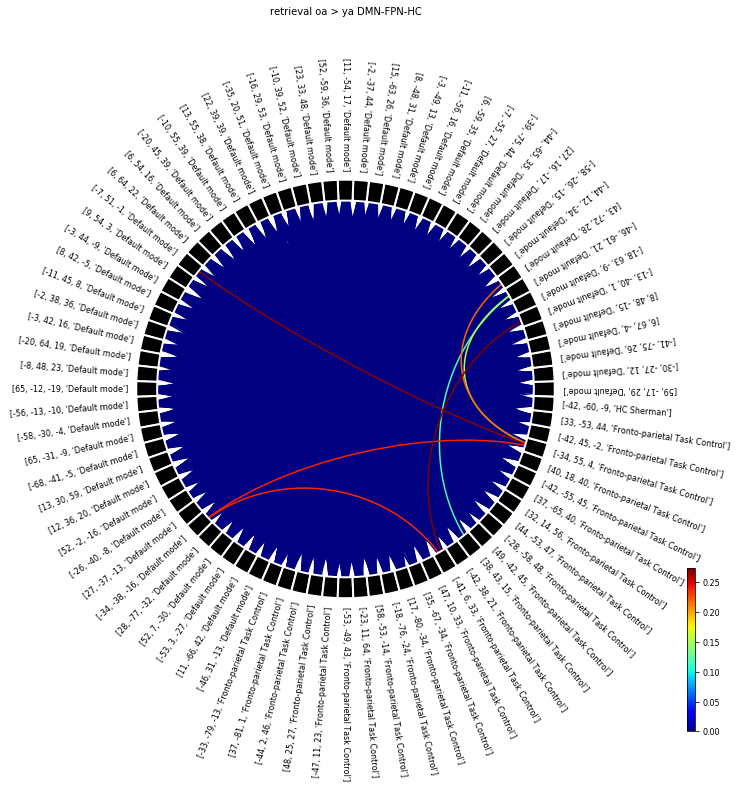

In [136]:
fig = plt.figure(figsize=(15, 15))
n_lines = int(np.sum((nbs_mat > 0) / 2))
node_labels = pd.DataFrame(np.hstack((coords, atlas.loc[dmn_fpn].values))).values.tolist()


plot_connectivity_circle(nbs_mat.mean(axis=2), node_labels, n_lines=n_lines, fig=fig, title='retrieval oa > ya DMN-FPN-HC', 
                         fontsize_title=10, facecolor='white', textcolor='black', 
                         colormap='jet', colorbar=1, node_colors=['black'], 
                         node_edgecolor=['white'], show=False, interactive=False)

In [137]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -34,55,4
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c 43,-72,28

<b>Harvard-Oxford Cortical Structural Atlas</b><br>71% Frontal Pole
<b>Harvard-Oxford Cortical Structural Atlas</b><br>60% Lateral Occipital Cortex, superior division


In [138]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -34,55,4
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -46,-61,21

<b>Harvard-Oxford Cortical Structural Atlas</b><br>71% Frontal Pole
<b>Harvard-Oxford Cortical Structural Atlas</b><br>36% Lateral Occipital Cortex, superior division, 25% Angular Gyrus, 2% Lateral Occipital Cortex, inferior division, 1% Middle Temporal Gyrus, temporooccipital part


In [139]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -34,55,4
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -7,51,-1

<b>Harvard-Oxford Cortical Structural Atlas</b><br>71% Frontal Pole
<b>Harvard-Oxford Cortical Structural Atlas</b><br>73% Paracingulate Gyrus, 6% Cingulate Gyrus, anterior division, 5% Frontal Medial Cortex, 4% Frontal Pole


In [140]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -34,55,4
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -34,-38,-16

<b>Harvard-Oxford Cortical Structural Atlas</b><br>71% Frontal Pole
<b>Harvard-Oxford Cortical Structural Atlas</b><br>48% Temporal Fusiform Cortex, posterior division, 10% Parahippocampal Gyrus, posterior division, 2% Temporal Occipital Fusiform Cortex


In [141]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -34,55,4
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c 43,-72,28

<b>Harvard-Oxford Cortical Structural Atlas</b><br>71% Frontal Pole
<b>Harvard-Oxford Cortical Structural Atlas</b><br>60% Lateral Occipital Cortex, superior division


In [142]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -41,6,33
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -13,-40,1

<b>Harvard-Oxford Cortical Structural Atlas</b><br>28% Precentral Gyrus, 28% Middle Frontal Gyrus, 12% Inferior Frontal Gyrus, pars opercularis
<b>Harvard-Oxford Cortical Structural Atlas</b><br>14% Cingulate Gyrus, posterior division, 10% Parahippocampal Gyrus, posterior division, 1% Lingual Gyrus


In [143]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -34,-38,-16
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -13,-40,1

<b>Harvard-Oxford Cortical Structural Atlas</b><br>48% Temporal Fusiform Cortex, posterior division, 10% Parahippocampal Gyrus, posterior division, 2% Temporal Occipital Fusiform Cortex
<b>Harvard-Oxford Cortical Structural Atlas</b><br>14% Cingulate Gyrus, posterior division, 10% Parahippocampal Gyrus, posterior division, 1% Lingual Gyrus


In [144]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c 38,43,15
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -46,-61,21

<b>Harvard-Oxford Cortical Structural Atlas</b><br>53% Frontal Pole, 3% Inferior Frontal Gyrus, pars triangularis, 3% Middle Frontal Gyrus
<b>Harvard-Oxford Cortical Structural Atlas</b><br>36% Lateral Occipital Cortex, superior division, 25% Angular Gyrus, 2% Lateral Occipital Cortex, inferior division, 1% Middle Temporal Gyrus, temporooccipital part


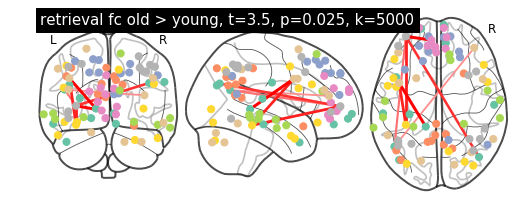

In [145]:
from nilearn import plotting

plotting.plot_connectome(nbs_mat.mean(axis=2), coords, edge_threshold=0, title='retrieval fc old > young, t=3.5, p=0.025, k=5000')



In [239]:
df0 = pd.read_csv('/Volumes/schnyer/Megan/adm_mem-fc/data/dataset_2021-11-10.csv')
df0['subject'] = df0['subject'].astype(str)
df = df0[df0['subject'].isin(fc_subs)]
df.head()

,subject,IS,IV,RA,L5,L5_starttime,M10,M10_starttime,duration_mean_active,duration_mean_daily,...,pc_dmn_fpn_18,pc_dmn_fpn_20,pc_dmn_fpn_mean,pc_dmn_mean,pc_fpn_mean,edge_0,edge_1,edge_2,edge_3,acc_mean_test_log
0,30004,0.43,0.57,0.85,12.61,19:54:30,156.15,5:17:30,937.071429,1263.428571,...,0.205587,0.218853,0.178769,0.585333,0.755358,0.451471,0.509899,0.257227,0.688757,-0.028171
1,30008,0.48,0.68,0.90,7.56,20:26:30,147.40,2:00:30,872.928571,1251.214286,...,0.206955,0.218107,0.194311,0.586016,0.720762,0.425655,0.824386,1.032888,0.311497,-0.057158
2,30009,0.42,1.31,0.92,11.58,19:34:30,286.35,6:21:30,981.214286,1317.000000,...,0.211377,0.222053,0.192073,0.482981,0.814453,0.508419,0.634550,0.578941,0.278736,-0.028171
4,30015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,899.857143,1438.714286,...,0.261610,0.277564,0.237269,0.651844,0.738657,0.264530,0.418911,0.402329,0.096133,-0.117783
5,30019,0.45,0.71,0.94,4.67,20:08:30,145.78,6:16:30,867.928571,1299.357143,...,0.318376,0.331827,0.302502,0.715599,0.830522,0.365178,0.379545,0.701750,0.334316,-0.057158


In [105]:
n_oa = 38
n_ya = 50

group = np.vstack((np.ones((n_ya,1)), -1*np.ones((n_oa,1))))
      
df_ya = df[df['Group'] == "Young Adults"]
df_oa = df[df['Group'] == "Older Adults"]

acc = np.array(df['acc_mean_test_log'] - df['acc_mean_test_log'].mean())
acc = np.nan_to_num(acc)

acc_int = acc.copy()
acc_int[50:] = acc_int[50:]*-1
acc_int = np.atleast_2d(acc_int).T

dsn_acc_int = np.hstack((np.ones((88,1)), group, np.atleast_2d(acc).T, acc_int))
dsn_acc = np.hstack((group, np.atleast_2d(acc).T))

savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/dsnmat_acc_int.mat', {'dsn_acc_int': dsn_acc_int})
savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/dsnmat_acc.mat', {'dsn_acc': dsn_acc})

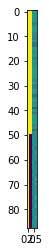

In [103]:
plt.imshow(dsn_acc_int)

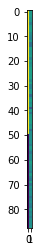

In [104]:
plt.imshow(dsn_acc)

In [9]:
adj = np.loadtxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/adj_dmn_fpn_acc_int_-1.txt')
coords = np.loadtxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/coords_dmn_fpn_hc.txt', dtype=int)
print(adj.shape)
nbs_mat = np.repeat(adj[:, :, np.newaxis], x['cue'].shape[2], axis=2)*x['cue'][dmn_fpn][:,dmn_fpn,:]
np.nonzero(nbs_mat[:,:,0])

np.fill_diagonal(adj, -1.0, wrap=False)
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/network_dmn_fpn_acc_int.edge', adj, fmt='%s', delimiter=' ')

(84, 84)


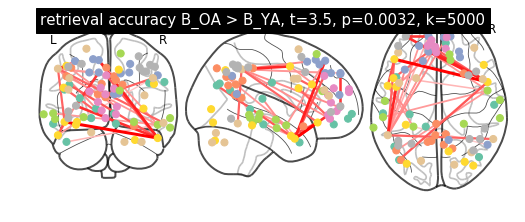

In [25]:
from nilearn import plotting

plotting.plot_connectome(nbs_mat.mean(axis=2), coords, edge_threshold=0, title='retrieval accuracy B_OA > B_YA, t=3.5, p=0.0032, k=5000')


In [24]:
edges_fc = pd.DataFrame(nbs_mat[np.where(np.triu(adj) == 1)].T)
edges_fc.columns = ['net_int_edge_' + str(col) for col in edges_fc.columns]
edges_fc['net_int_mean'] = edges_fc.mean(axis=1)
edges_fc['subject'] = fc_subs
edges_fc.to_csv('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/edgesdf_accInt.csv', index=False)
edges_fc.head()

,net_int_edge_0,net_int_edge_1,net_int_edge_2,net_int_edge_3,net_int_edge_4,net_int_edge_5,net_int_edge_6,net_int_edge_7,net_int_edge_8,net_int_edge_9,...,net_int_edge_17,net_int_edge_18,net_int_edge_19,net_int_edge_20,net_int_edge_21,net_int_edge_22,net_int_edge_23,net_int_edge_24,net_int_mean,subject
0,0.179047,0.629685,-0.021118,0.116189,0.234948,0.060991,0.435965,0.086447,-0.271760,0.061167,...,0.220779,0.124181,0.902367,0.518075,0.264511,0.078776,0.082256,0.034190,0.166284,30004
1,0.368643,0.190595,0.055094,0.423159,-0.075031,0.178001,0.317974,-0.066213,-0.177934,-0.211042,...,0.063963,0.050698,0.350308,-0.051345,0.715150,0.175801,0.100041,0.201320,0.185355,30008
2,-0.276892,0.143173,0.261794,-0.202056,0.184446,0.093699,0.165643,-0.077836,0.145742,0.172590,...,0.179959,-0.215441,0.247096,0.266367,0.087500,0.601327,0.353431,0.064098,0.095987,30009
3,0.193581,0.247928,0.191497,-0.281633,-0.046773,-0.014603,0.345636,0.222602,0.186344,0.973710,...,0.245444,-0.002195,0.170260,0.280842,-0.048092,0.396378,0.034333,0.198603,0.148735,30015
4,-0.103271,0.472003,-0.070873,0.247862,-0.192653,0.190719,0.064752,0.192385,0.356685,-0.099859,...,0.217701,-0.007124,0.083271,0.275252,0.199058,-0.004326,0.601495,0.428484,0.210757,30019


(<Figure size 1080x1080 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x136375f10>)

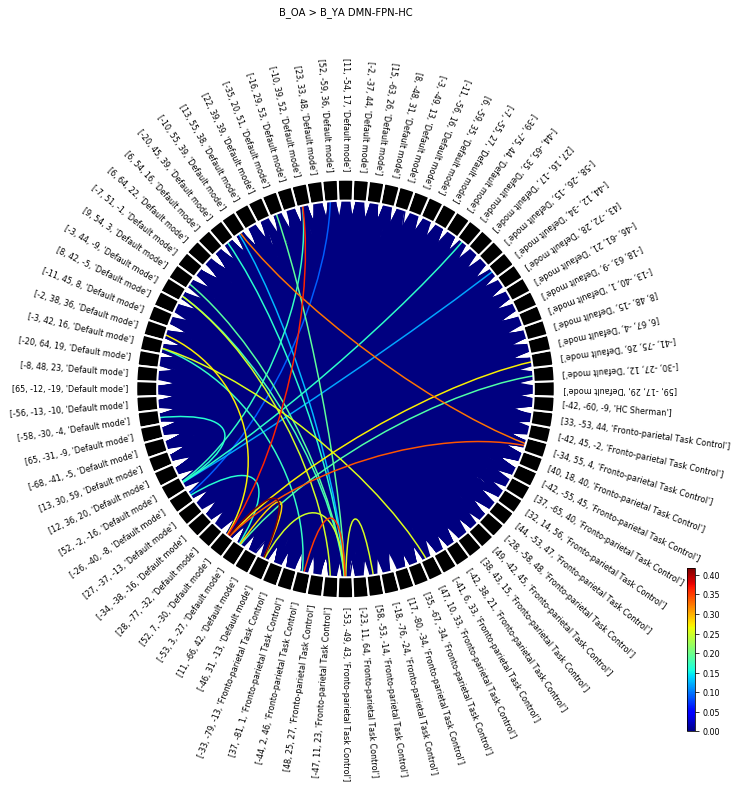

In [26]:
fig = plt.figure(figsize=(15, 15))
n_lines = int(np.sum((nbs_mat > 0) / 2))
node_labels = pd.DataFrame(np.hstack((coords, atlas.loc[dmn_fpn].values))).values.tolist()


plot_connectivity_circle(nbs_mat.mean(axis=2), node_labels, n_lines=n_lines, fig=fig, title='B_OA > B_YA DMN-FPN-HC', 
                         fontsize_title=10, facecolor='white', textcolor='black', 
                         colormap='jet', colorbar=1, node_colors=['black'], 
                         node_edgecolor=['white'], show=False, interactive=False)

In [72]:
edgesList0 = list([np.where(np.triu(adj) == 1)][0][0])
edgesList1 = list([np.where(np.triu(adj) == 1)][0][1])
pd.DataFrame(node_labels).loc[edgesList0].reset_index(drop=True)

,0,1,2,3
0,-30,-27,12,Default mode
1,-41,-75,26,Default mode
2,-44,12,-34,Default mode
3,-44,-65,35,Default mode
4,52,-59,36,Default mode
5,-10,39,52,Default mode
6,-10,39,52,Default mode
7,-35,20,51,Default mode
8,-10,55,39,Default mode
9,-10,55,39,Default mode


In [73]:
pd.DataFrame(node_labels).loc[edgesList1].reset_index(drop=True)

,0,1,2,3
0,-53,3,-27,Default mode
1,52,7,-30,Default mode
2,52,-2,-16,Default mode
3,52,-2,-16,Default mode
4,-26,-40,-8,Default mode
5,52,-2,-16,Default mode
6,52,7,-30,Default mode
7,-53,-49,43,Fronto-parietal Task Control
8,-53,-49,43,Fronto-parietal Task Control
9,-34,55,4,Fronto-parietal Task Control


In [66]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -44,2,46
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -53,-49,43

<b>Harvard-Oxford Cortical Structural Atlas</b><br>41% Precentral Gyrus, 26% Middle Frontal Gyrus
<b>Harvard-Oxford Cortical Structural Atlas</b><br>46% Supramarginal Gyrus, posterior division, 32% Angular Gyrus, 3% Supramarginal Gyrus, anterior division, 2% Lateral Occipital Cortex, superior division


In [11]:
# edges = pd.DataFrame(np.hstack((coords, atlas.loc[dmn_fpn].values)))
# edges[[3]] = np.where(edges[[3]] == 'Default mode', 0, edges[[3]])
# edges[[3]] = np.where(edges[[3]] == 'Fronto-parietal Task Control', 1, edges[[3]])
# edges[[3]] = np.where(edges[[3]] == 'HC Sherman', 2, edges[[3]])
# edges['new'] = 1
# edges['newnew'] = 1
# edges.to_csv('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/dmnfpn_hc.node', index=False, header=None, sep=' ')

https://www.nitrc.org/forum/message.php?msg_id=22465